In [ ]:
import torch
import torch.nn as  nn
import torchvision.datasets as datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np
import torch.nn.functional as F

### Define model

In [ ]:
class Generator(nn.Module):
  """
  A simple MLP architecture with one hidden layer.
  """
  def __init__(self, input_dim, hidden_dim=256, output_dim=784, output_shape=(28, 28)):
    super(Generator, self).__init__()
    # Define linear layers
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.activation1 = nn.LeakyReLU(0.2)

    self.fc2 = nn.Linear(hidden_dim, output_dim)
    self.activation2 = nn.Tanh()

    # Initialize linear layers with Xavier method
    nn.init.xavier_normal_(self.fc1.weight)
    nn.init.xavier_normal_(self.fc2.weight)
    # Define activations
    self.output_shape = output_shape

  def forward(self, z):
      x = self.activation1(self.fc1(z))
      x = self.fc2(x)
      #x = nn.Dropout(0.2)(x)
      x = nn.Sigmoid()(x)
      s = (-1, self.output_shape[0], self.output_shape[1]) 
      return x.reshape(s)

In [ ]:
class ConvGenerator(nn.Module):
    """
    A convolutional network for image generation, inspired from DCGAN. Adapted from the architecture described in the
    OT-GAN paper to adapt to the simpler MNIST images.
    Mode: 'mnist' or 'cifar'. Defines the complexity of the architecture.
    """
    def __init__(self, input_dim, output_channels=None):
        super(ConvGenerator, self).__init__()
        
        output_channels = 1
        self.dim1, self.dim2, self.dim3, self.dim4, self.dim5 = 8192, 256, 128, 64, 32
        self.kernel_size = 3


        self.fc1 = nn.Linear(input_dim, self.dim1)
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv1 = nn.Conv2d(self.dim2, self.dim2, kernel_size=self.kernel_size, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.dim3, self.dim3, kernel_size=self.kernel_size, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.dim4, self.dim4, kernel_size=self.kernel_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(self.dim5, output_channels, kernel_size=self.kernel_size, stride=1, padding=1)

        self.activation1 = nn.GLU(dim=1)
        self.activation2 = nn.Tanh()

    def forward(self, z):

        x = self.fc1(z)
        x = self.activation1(x)
        x = x.view(-1, self.dim2, 4, 4)

        x = self.upsample(x)
        x = self.activation1(self.conv1(x))
        x = self.upsample(x)
        x = self.activation1(self.conv2(x))
        x = self.upsample(x)
        x = self.activation1(self.conv3(x))
        x = self.activation2(self.conv4(x))

        return x

In [ ]:
class Critic(nn.Module):
    """
    A simple MLP architecture with one hidden layer.
    """
    def __init__(self, input_dim=784, hidden_dim=256, output_dim=100):
        super(Critic, self).__init__()
        self.input_dim = input_dim
        
        # Define linear layers
        self.fc1 = nn.Linear(self.input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # Initialize linear layers with Xavier method
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        # Define activations
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = x.view(-1, self.input_dim)  # Flatten x
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        x = F.normalize(x, dim=1, p=2, eps=1e-12)
        return x

In [ ]:
class ConvCritic(nn.Module):
    def __init__(self, in_channel =3,kernel_size=5):
        super(Discriminator, self).__init__()
        conv1_channels = 64
        conv_padding_size = (kernel_size - 1) // 2

        self.conv1 = nn.Conv2d(in_channel,conv1_channels , kernel_size,padding=conv_padding_size)
        self.conv2 = nn.Conv2d(conv1_channels*2, conv1_channels*2, kernel_size, 
                               stride=2, padding=conv_padding_size)
        self.conv3 = nn.Conv2d(conv1_channels*4, conv1_channels*4, kernel_size, 
                               stride=2, padding=conv_padding_size)

    def forward(self, x):
        x = self.conv1(x) #  (batch_size, 64, 32, 32)
        x = torch.cat((F.relu(x), F.relu(-x)), 1) # (batch_size, 128, 32, 32)
        x = self.conv2(x) # (batch_size, 128, 16, 16)
        x = torch.cat((F.relu(x), F.relu(-x)), 1) # (batch_size, 256, 16, 16)
        x = self.conv3(x) # (batch_size, 256, 8, 8)
        x = torch.cat((F.relu(x), F.relu(-x)), 1) # (batch_size, 512, 8, 8)
        x = nn.Flatten()(x) # (batch_size, 32768)
        x = F.normalize(x, dim=1, p=2) # (batch_size, 32768)
        return x # (batch_size, 32768)

### Load dataset

In [ ]:
from torch.utils.data import Dataset

class MNIST_Dataset(Dataset):
  def __init__(self, X, X_prim, transform=torch.FloatTensor):
    self.X = torch.from_numpy(X)
    self.X_prim = torch.from_numpy(X_prim)
    self.n = len(self.X)
    self.transform = transform

  def __getitem__(self, index):
    #idx = torch.randint(0, self.n, (1,))
    #print(idx)
    X, X_prim = self.X[index], self.X_prim[index].squeeze()

    X, X_prim = X.type(self.transform), X_prim.type(self.transform)
    return X, X_prim
    
  def __len__(self):
    return len(self.X)

In [ ]:
# Get MNIST pictures as Torch dataloader
(mnist_data, _), (_, _) = mnist.load_data() # We only care about images
mnist_data = mnist_data / 255. # normalize

In [ ]:
# Compute two shuffled MNIST datasets
mnist_data1 = mnist_data[np.random.permutation(mnist_data.shape[0]), :, :]
mnist_data2 = mnist_data[np.random.permutation(mnist_data.shape[0]), :, :]

In [ ]:
mnist_dataset = MNIST_Dataset(mnist_data1, mnist_data2)

### create dataloader
batch_size = 256
train_dataloader = torch.utils.data.DataLoader(dataset=mnist_dataset,
                                  batch_size=batch_size, shuffle=True)

In [ ]:
samples, s = next(iter(train_dataloader))

In [ ]:
print(samples.shape, s.shape)

torch.Size([256, 28, 28]) torch.Size([256, 28, 28])


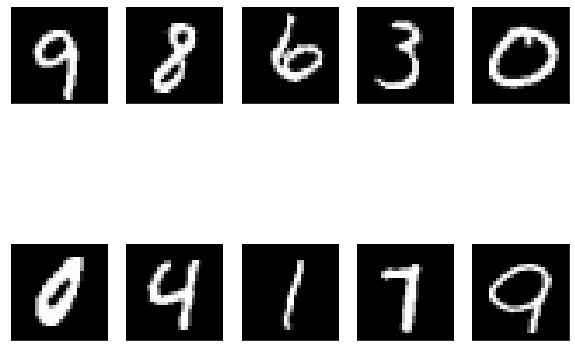

In [ ]:
plt.figure(figsize=(10,8))
for i in range(10):
    plt.subplot(2,5,i+1, xticks=[], yticks=[])
    plt.imshow(samples[i].squeeze(),cmap='gray')
plt.show()

### Create a Pytorch dataset

In [ ]:
import numpy as np
from tqdm import tqdm
import torch.optim as optim

In [ ]:
class GAN:
  def __init__(self, z_dim, output_dim, dataloader, device, type_training="OTGAN", conv):
    self.z_dim = z_dim
    self.dataloader = dataloader
    self.conv = conv #booleen qui définit quel réseaux on utilise
    if conv:
      self.generator = ConvGenerator(z_dim).to(device)
      self.critic = ConvCritic(output_dim=output_dim).to(device)
    else:
      self.generator = Generator(z_dim).to(device)
      self.critic = Critic(output_dim=output_dim).to(device)
    self.device = device
    self.type_training = type_training
    self.pdist = nn.PairwiseDistance(p=2) #pairwise distance norm

  def sample_data(self, n_sample=100):
    # Generate noises to create images from
    a = np.random.randn(n_sample, self.z_dim)
    z1 = torch.FloatTensor(a).to(self.device)
    return self.generator(z1)  
  
  def sinkhorn(self, a, b, C, reg=0.01, max_iters=10):
    #K = torch.exp(-C/reg).detach()
    K = torch.exp(-C/reg)
    v = torch.ones_like(b).to(self.device)

    for i in range(max_iters):
      u = a / (torch.matmul(K,v) + 1e-8)
      v = b / (torch.matmul(K.T,u) + 1e-8)
    return torch.matmul(torch.diag(u), torch.matmul(K, torch.diag(v)))  # Optimal matching

  def cost(self, x, y):
    if self.type_training == "OTGAN":
      return 1.0 - (x @ y.mT)
    else:
      return self.pdist(x, y)

  def loss(self, X, X_prim, Y, Y_prim, reg=0.1):
    if self.type_training == "OTGAN":
      pairs = [(1, "X", "Y"), (1, "X", "Y_prim"), (1, "X_prim", "Y"), (1, "X_prim", "Y_prim"), (-2, "X", "X_prim"), (-2, "Y", "Y_prim")]
    else:
      pairs = [(2, "X", "Y"), (-1, "X", "X_prim"), (-1, "Y", "Y_prim")]
    
    batch_size = X.shape[0]
    a = torch.ones(batch_size).to(self.device) / batch_size
    b = torch.ones(batch_size).to(self.device) / batch_size
    l = 0
    for (const, key1, key2) in pairs:
      # compute cost
      co = self.cost(eval(key1), eval(key2))
      # compute optimal plan
      M = self.sinkhorn(a, b, co, reg=reg)  
      # compute cost
      l = l + const * torch.sum(M * co)

    return l


  def train(self, epochs=200, n_gen=5, lr=1e-4, reg=0.1):
    c_optimizer = optim.Adam(self.critic.parameters(), lr=lr)
    g_optimizer = optim.Adam(self.generator.parameters(), lr=lr)

    for epoch in range(0, epochs):
      pbar = tqdm(self.dataloader, desc=f"Training {self.type_training}")
      for id_b, (real1, real2) in enumerate(pbar): 

        ### Set train mode
        self.generator.train()
        self.critic.train()

        batch_size = real1.shape[0]
        real1, real2 = real1.to(self.device), real2.to(self.device) 
        fake1 = self.sample_data(n_sample=batch_size)
        fake2 = self.sample_data(n_sample=batch_size)

        X, X_prim, Y, Y_prim = self.critic(real1), self.critic(real2), self.critic(fake1), self.critic(fake2)
        

        l = self.loss(X, X_prim, Y, Y_prim, reg=reg)
        c_optimizer.zero_grad()
        g_optimizer.zero_grad()

        if id_b % n_gen == 0:
          (-l).backward()
          c_optimizer.step()
        else:
          l.backward()  # to minimize
          g_optimizer.step()

        pbar.set_postfix(Epoch=epoch + 1 , loss=l.detach().cpu().item())
      
      if epoch % 5 == 0:
        self.generator.eval()

        plt.figure(figsize=(10,8))
        samples = self.sample_data(30)
        samples = samples.detach().cpu()
        affichage_image(samples)

In [ ]:
def affichage_image(X_gen, rows=5, cols=6, pad=3, n_data=30):
  plt.figure(figsize=[5,5]) 
  for i in range(1, n_data+1):
      plt.subplot(rows, cols, i,xticks=[],yticks=[])
      plt.imshow(X_gen[i-1,:], cmap='gray')
  plt.tight_layout(pad=pad, h_pad = 0, w_pad = 0)
  plt.show();

In [ ]:
z_dim = 100
output_dim = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataloader = torch.utils.data.DataLoader(dataset=mnist_dataset,
                                  batch_size=200, shuffle=True)

In [ ]:
#OTgan = GAN(z_dim, output_dim, train_dataloader, device,  type_training="OTGAN")
AutoDiffgan = GAN(z_dim, output_dim, train_dataloader, device,  type_training="Auto-diff")

Training Auto-dif: 100%|██████████| 300/300 [00:17<00:00, 17.46it/s, Epoch=1, loss=0.00571]


<Figure size 720x576 with 0 Axes>

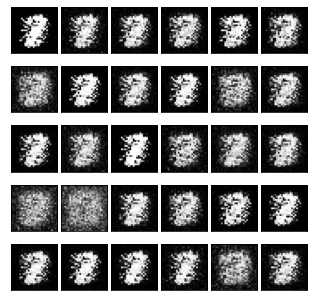

Training Auto-dif: 100%|██████████| 300/300 [00:17<00:00, 17.03it/s, Epoch=6, loss=0.00105]


<Figure size 720x576 with 0 Axes>

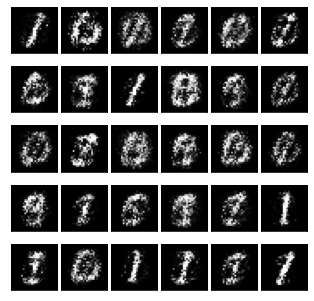

Training Auto-dif: 100%|██████████| 300/300 [00:17<00:00, 17.15it/s, Epoch=11, loss=0.00128]


<Figure size 720x576 with 0 Axes>

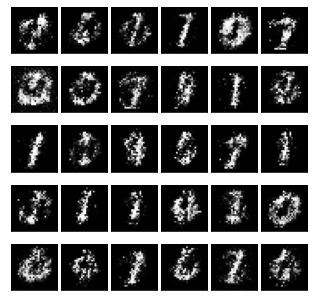

Training Auto-dif: 100%|██████████| 300/300 [00:18<00:00, 16.49it/s, Epoch=16, loss=0.000956]


<Figure size 720x576 with 0 Axes>

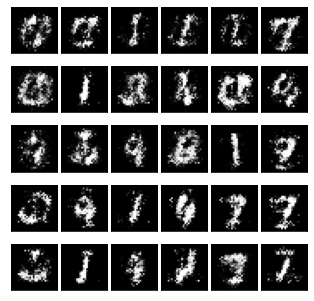

Training Auto-dif: 100%|██████████| 300/300 [00:18<00:00, 16.24it/s, Epoch=21, loss=0.00342]


<Figure size 720x576 with 0 Axes>

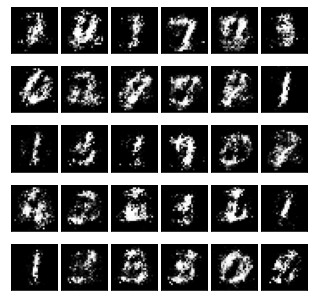

Training Auto-dif: 100%|██████████| 300/300 [00:19<00:00, 15.73it/s, Epoch=26, loss=0.000694]


<Figure size 720x576 with 0 Axes>

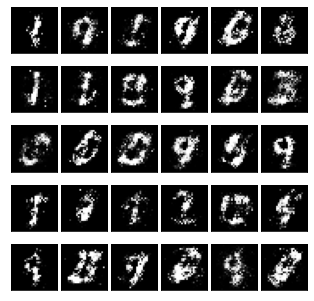

Training Auto-dif: 100%|██████████| 300/300 [00:19<00:00, 15.75it/s, Epoch=30, loss=0.00128]


In [ ]:
#OTgan.train(n_gen=5, lr=1e-3, reg=0.1,  epochs=500)
AutoDiffgan.train(n_gen=5, lr=1e-3, reg=0.08,  epochs=30)

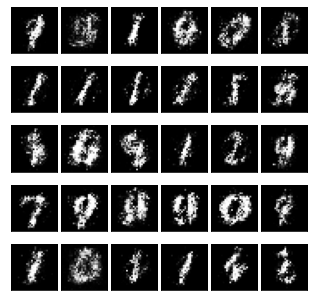

In [ ]:
samples =  AutoDiffgan.sample_data() #to sample data from the generator
samples = samples.detach().cpu()
affichage_image(samples)
